In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
import os
import csv
from datetime import datetime
from scipy.optimize import curve_fit


### 读取文件

In [2]:
def readSalesWeight(filename):
    length = 0
    sales_weight = []
    with open(filename, 'r', encoding='UTF-8', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row[1].isdigit():
                continue
            length += 1
            sales_weight.append(row[2])
    return sales_weight, length

In [3]:
def readSoldVolumeFile(source_father_path):
    singleSalesDict = {}
    singleSalesLengthDict = {}
    for root, _, files in os.walk(source_father_path):
        for file in files:
            filePath = os.path.join(root, file)
            sale_weight_lst, sales_weight_length = readSalesWeight(filePath)
            # print(file)
            category = file.split('日')[0]
            if category not in singleSalesDict:
                singleSalesDict[category] = sale_weight_lst
                singleSalesLengthDict[category] = sales_weight_length

    return singleSalesDict, singleSalesLengthDict

In [4]:
sold_Volume_dict, sold_days_dict = readSoldVolumeFile('D:\Git\国赛\data\销售量数据\品类\每日')

In [6]:
sold_days_dict

{'水生根茎类': 1095, '花叶类': 1095, '花菜类': 1095, '茄类': 1095, '辣椒类': 1095, '食用菌': 1095}

In [7]:
def readAveragePrice(source_path):
    averagePricesDict = {}
    timestampDict = {}
    for root, _, files in os.walk(source_path):
        for file in files:
            averagePrices = []
            timestamp = []
            if not file.__contains__("平均价格"):
                continue
            category = file.split('_')[1].strip(".csv")
            print(file)
            filename = os.path.join(root, file)

            with open(filename, 'r', encoding='UTF-8', newline='') as f:
                reader = csv.reader(f)
                for row in reader:

                    if not row[0].isdigit():
                        continue
                    averagePrices.append(row[2])
                    timestamp.append(datetime.strptime(row[1], "%Y-%m-%d"))
                    # print(timestamp[-1])
            if category not in averagePricesDict:
                averagePricesDict[category] = averagePrices
                timestampDict[category] = timestamp
    return averagePricesDict, timestampDict

In [8]:
average_prices_dict, timestamp_dict = readAveragePrice('D:\Git\国赛\data\销售单价\品类')

平均价格_水生根茎类.csv
平均价格_花叶类.csv
平均价格_花菜类.csv
平均价格_茄类.csv
平均价格_辣椒类.csv
平均价格_食用菌.csv


### 展示销售总量与成本加成定价的关系

In [10]:
def showScatterVolume2Price(x_data_array, y_data_array):
    plt.scatter(x_data_array, y_data_array, label='Data')
    # plt.plot(x_data_array, y_data_array, label='Data Curve', color='blue')
    # label_lst = [(label + str(i)) for i in range(len(corr_matrix))]
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())  # 不显示x轴标签文本
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # 不显示y轴标签文本
    plt.legend()
    plt.show()

In [11]:
def showScatterVolume2PriceOn1Figure(averagePricesDict, soldVolumeDict):
    clusterIndex = 0
    for key, item in average_prices_dict.items():
        clusterIndex += 1
        print(key)
        item1 = np.array(item)
        item2 = item1.astype('float')
        # item_log = np.log(item2)

        value = sold_Volume_dict[key]
        value1 = np.array(value)
        value2 = value1.astype('float')
        # value_log = np.log(value2)
        print(item2)
        plt.scatter(item2, value2, label='Data'+str(clusterIndex))
        plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())  # 不显示x轴标签文本
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())  # 不显示y轴标签文本
    plt.legend()
    plt.savefig(r'D:\Git\国赛\result\Q2\散点图.jpg')
    plt.show()

水生根茎类
[ 49.8         47.6          8.2        ...  66.53333333 119.3
 107.84975025]
花叶类
[136.98103448 132.20239122 133.67546157 ...  60.9740932   67.41945055
  61.09951515]
花菜类
[23.         23.         22.         ... 26.         24.57777778
 23.11666667]
茄类
[10.  11.  11.  ... 29.2 38.2 23.2]
辣椒类
[125.4        129.4        131.4        ...  80.81897436  81.40285088
  60.96111111]
食用菌
[63.95       65.8        66.8        ... 44.68461538 41.90995671
 44.02735043]


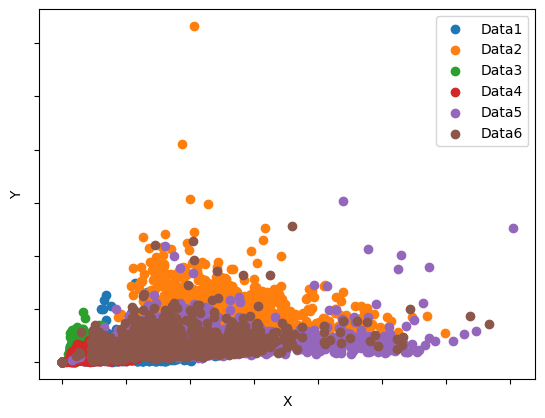

In [12]:
showScatterVolume2PriceOn1Figure(average_prices_dict, sold_Volume_dict)

### 拟合销售总量与成本加成定价的关系

In [14]:
def range_standardization(data_array):
    """
    对输入的NumPy数组进行极差标准化，并返回标准化后的数组。

    参数：
    data: 输入的NumPy数组

    返回值：
    标准化后的NumPy数组
    """
    min_value = np.min(data_array)
    max_value = np.max(data_array)
    range_data = max_value - min_value

    # 极差标准化公式：(x - min) / (max - min)
    standardized_data = (data_array - min_value) / range_data

    return standardized_data

def standardizeDict(interpolated_dict):

    standardized_dict = {}
    for key, item in interpolated_dict.items():
        temp_item1 = np.array(item)
        temp_item2 = temp_item1.astype('float')
        standardized_item = range_standardization(temp_item2)
        standardized_dict[key] = standardized_item
    return standardized_dict

水生根茎类
[ 49.8         47.6          8.2        ...  66.53333333 119.3
 107.84975025]
花叶类
[136.98103448 132.20239122 133.67546157 ...  60.9740932   67.41945055
  61.09951515]
花菜类
[23.         23.         22.         ... 26.         24.57777778
 23.11666667]
茄类
[10.  11.  11.  ... 29.2 38.2 23.2]
辣椒类
[125.4        129.4        131.4        ...  80.81897436  81.40285088
  60.96111111]
食用菌
[63.95       65.8        66.8        ... 44.68461538 41.90995671
 44.02735043]


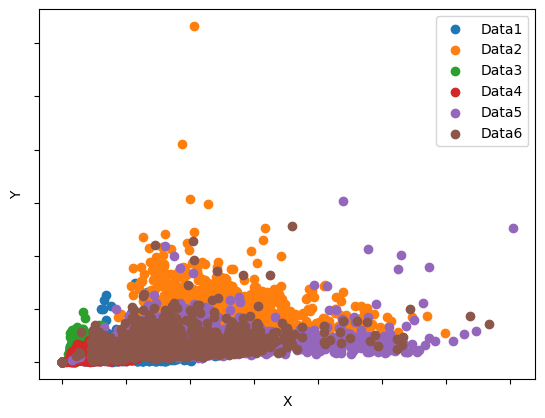

In [15]:
standardized_average_prices_dict = standardizeDict(average_prices_dict)
standardized_sold_Volume_dict = standardizeDict(sold_Volume_dict)
showScatterVolume2PriceOn1Figure(standardized_average_prices_dict, standardized_sold_Volume_dict)

### 平滑处理以及丢弃窗口极值

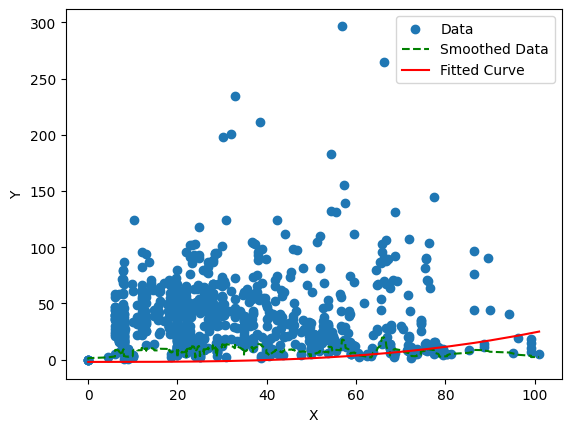

Fitted Parameters: a = 2.6187804905930534e-05, b = 1.9990042448043823, c = 0.0009966306388378143
Loss: 69393.09713580995


In [16]:


# 示例数据
x_data = np.array(average_prices_dict['水生根茎类'][:int(len(average_prices_dict['水生根茎类'])*0.8)]).astype('float32')
y_data = np.array(sold_Volume_dict['水生根茎类'][:int(len(sold_Volume_dict['水生根茎类'])*0.8)]).astype('float32')
x_predict = np.array(average_prices_dict['水生根茎类']).astype('float32')

# 使用argsort()对x_data进行排序并获取排序后的索引
sorted_indices = np.argsort(x_data)
x_data_sorted = x_data[sorted_indices]
y_data_sorted = y_data[sorted_indices]

# 定义平滑窗口大小
window_size = 7

# 对y_data_sorted进行平滑处理
smoothed_y_data = np.convolve(y_data_sorted, np.ones(window_size)/window_size, mode='same')

# 获取平滑后的y_data，长度与之前一致
y_data_smoothed = smoothed_y_data[:len(y_data_sorted)]

# 丢弃每个窗口中的最小值和最大值
for i in range(len(y_data_smoothed)):
    start = max(0, i - window_size // 2)
    end = min(len(y_data_smoothed), i + window_size // 2 + 1)
    window = y_data_smoothed[start:end]
    window = np.delete(window, np.argmin(window))
    window = np.delete(window, np.argmax(window))
    smoothed_y_data[i] = np.mean(window)

# 最后除以5
smoothed_y_data /= 5

# 定义非线性模型 a * np.exp(b * x) + c
def nonlinear_model(x, a, b, c):
    return  a * (x  )**3 - b + c

# 定义损失函数：均方误差
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# 初始化模型参数
a = tf.Variable(1.0, dtype=tf.float32)
b = tf.Variable(1.0, dtype=tf.float32)
c = tf.Variable(1.0, dtype=tf.float32)

# 使用Adam优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# 训练模型
epochs = 500
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = nonlinear_model(x_data_sorted, a, b, c)
        loss = loss_function(y_data_smoothed, y_pred)
    gradients = tape.gradient(loss, [a, b, c])
    optimizer.apply_gradients(zip(gradients, [a, b, c]))

# 获取拟合的参数
a_fit, b_fit, c_fit = a.numpy(), b.numpy(), c.numpy()

# 生成拟合曲线的预测值
y_fit = nonlinear_model(x_data_sorted, a_fit, b_fit, c_fit)

# 绘制原始数据、平滑数据和拟合曲线
plt.scatter(x_data_sorted, y_data_sorted, label='Data')
plt.plot(x_data_sorted, y_data_smoothed, label='Smoothed Data', color='green', linestyle='--')
plt.plot(x_data_sorted, y_fit, label='Fitted Curve', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# 打印拟合的参数
print(f'Fitted Parameters: a = {a_fit}, b = {b_fit}, c = {c_fit}')

# 计算残差平方和作为损失值
residuals = y_data_smoothed - y_fit
loss = np.sum(residuals**2)

# 打印损失值
print(f'Loss: {loss}')


## 傅里叶变换+低通滤波器+傅里叶反变换

F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


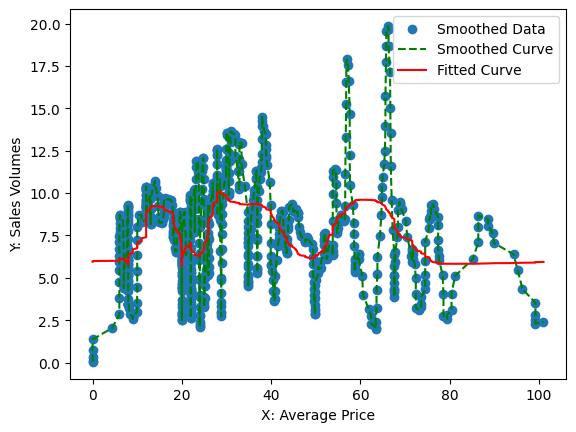

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (5977.216345586369-7.270169781320995e-16j)


F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


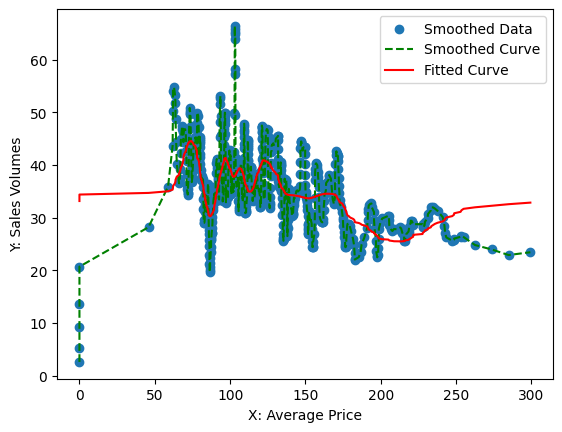

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (27107.303250340177+4.250789905786858e-14j)


F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


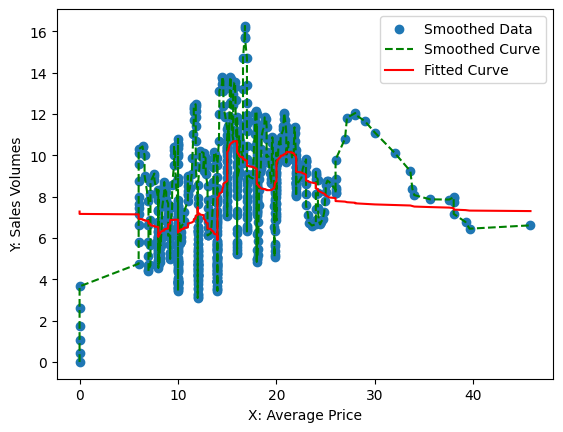

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (3565.564068304454-1.7512607756118885e-15j)


F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


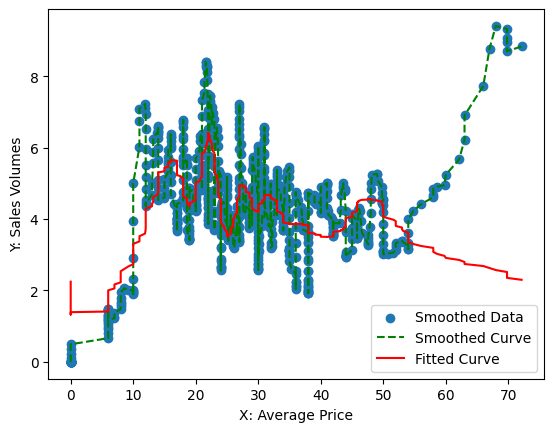

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (1255.876170367349-1.6663392348069866e-17j)


F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


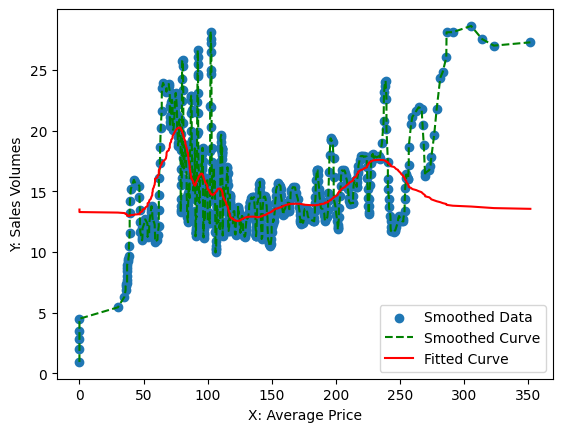

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (8939.189855745746+7.876107072789408e-15j)


F:\Anaconda3 2022.10\envs\DL\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


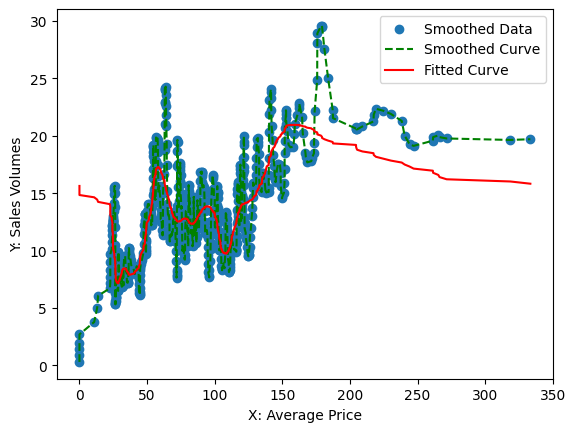

Fitted Parameters: No explicit parameters for Fourier series fit
 x_data_sorted  876
 y_fit  876
Loss: (6666.849616660509+9.27036767737315e-15j)


In [100]:
target_average_prices_dict = average_prices_dict
target_sold_Volume_dict = sold_Volume_dict
y_fft_dict = {}
x_fft_dict = {}
for key, item in target_average_prices_dict.items():

    # 示例数据
    x_data = np.array(item[:int(len(item) * 0.8)]).astype('float32')
    y_data = np.array(target_sold_Volume_dict[key][:int(len(target_sold_Volume_dict[key]) * 0.8)]).astype('float32')
    # x_predict = np.array(average_prices_dict[key]).astype('float32')

    # 使用argsort()对x_data进行排序并获取排序后的索引
    sorted_indices = np.argsort(x_data)
    x_data_sorted = x_data[sorted_indices]
    y_data_sorted = y_data[sorted_indices]

    # 定义平滑窗口大小
    window_size = 7

    # 对y_data_sorted进行平滑处理
    smoothed_y_data = np.convolve(y_data_sorted, np.ones(window_size) / window_size, mode='same')

    # 获取平滑后的y_data，长度与之前一致
    y_data_smoothed = smoothed_y_data[:len(y_data_sorted)]

    # 丢弃每个窗口中的最小值和最大值
    for i in range(len(y_data_smoothed)):
        start = max(0, i - window_size // 2)
        end = min(len(y_data_smoothed), i + window_size // 2 + 1)
        window = y_data_smoothed[start:end]
        window = np.delete(window, np.argmin(window))
        window = np.delete(window, np.argmax(window))
        smoothed_y_data[i] = np.mean(window)

    # 最后除以5
    smoothed_y_data /= window_size - 2

    # 计算傅里叶变换
    y_data_fft = fft(smoothed_y_data)

    # 设置最大限制频率
    max_frequency = 2 * np.pi / 800  # 例如，这里将最大限制频率设置为0.1，可以根据需要进行调整

    # 将高频部分截断（将高于最大限制频率的频率系数置零）
    num_samples = len(y_data_fft)
    frequency_values = np.fft.fftfreq(num_samples)
    y_data_fft[np.abs(frequency_values) > max_frequency] = 0

    # 计算傅里叶级数的逆变换以获得拟合的曲线
    y_fit = ifft(y_data_fft)

    # 绘制原始数据、平滑数据和拟合曲线
    plt.scatter(x_data_sorted, y_data_smoothed, label='Smoothed Data')
    plt.plot(x_data_sorted, y_data_smoothed, label='Smoothed Curve', color='green', linestyle='--')
    plt.plot(x_data_sorted, y_fit, label='Fitted Curve', color='red')
    plt.xlabel('X: Average Price')
    plt.ylabel('Y: Sales Volumes')
    plt.legend()
    plt.savefig('D:\\Git\\国赛\\result\\Q2\\'+key+'_低频傅里叶级数拟合结果.jpg')
    plt.show()
    # 打印拟合的参数（这里没有明确的参数，因为使用了傅里叶级数进行拟合）
    print('Fitted Parameters: No explicit parameters for Fourier series fit')

    # 计算残差平方和作为损失值
    residuals = y_data_smoothed - y_fit
    loss = np.sum(residuals**2)
    print( " x_data_sorted ", len(x_data_sorted))
    print( " y_fit ", len(y_fit))
    # 打印损失值
    print(f'Loss: {loss}')

    x_fft_dict[key] = x_data_sorted
    y_fft_dict[key] = y_fit

### 保存结果

In [102]:
def set_elements_to_zero(lst: list, scaleSize: float):
    # 计算列表的长度
    length = len(lst)
    new_lst = lst.copy()
    # 计算前10%和后10%的元素数量
    num_elements_to_zero = length // 10

    # 将前20%的元素设置为0
    for i in range(num_elements_to_zero * 2):
        new_lst[i] = max(lst)*0.3
    for i in range(num_elements_to_zero):
        new_lst[i] = 0 # -max(lst)*scaleSize

    # 将后20%的元素设置为0
    for i in range(length - num_elements_to_zero*2 , length):
        new_lst[i] = max(lst)*0.3
    for i in range(length - num_elements_to_zero , length):
        new_lst[i] = 0 # -max(lst)*scaleSize

    new_lst = [num.real if isinstance(num, complex) else num for num in new_lst]
    return np.array(new_lst)
for key, item in y_fft_dict.items():
    # temp_item_x = set_elements_to_zero(x_fft_dict[key])
    temp_item_y = set_elements_to_zero(item, 0.8)
    y_fft_dict[key] = temp_item_y


In [103]:
header = ['价格（元）', '销售重量（kg）']
for key, item in y_fft_dict.items():
    filename = os.path.join(r'D:\Git\国赛\result\Q2', key + '_价格-销售重量关系.csv')
    with open(filename, 'w', encoding='UTF-8', newline='')as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for index, value in enumerate(item):
            # if x_fft_dict[key][index]
            writer.writerow([x_fft_dict[key][index], value])

# DEBUG（无需运行，仅供调试）

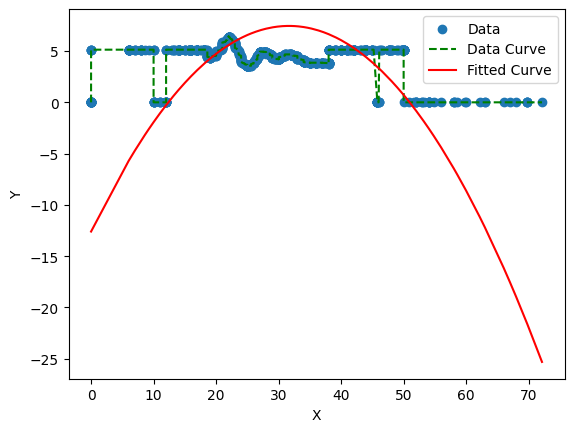

Fitted Parameters: a = 3.724299430847168, b = 4.405426979064941, c = 3.724299430847168
Loss: 18845.29519945818


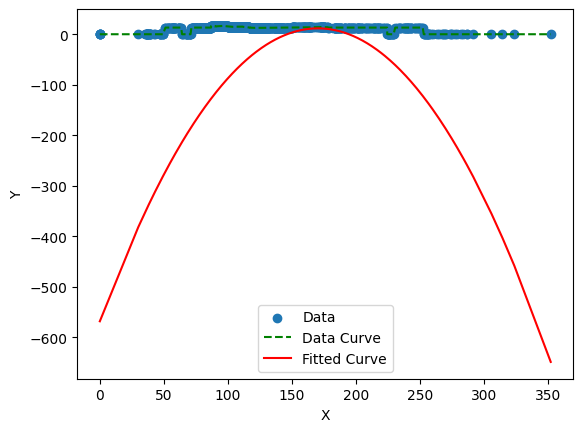

Fitted Parameters: a = 5.822648048400879, b = 5.712295055389404, c = 5.822648048400879
Loss: 15761599.357303772


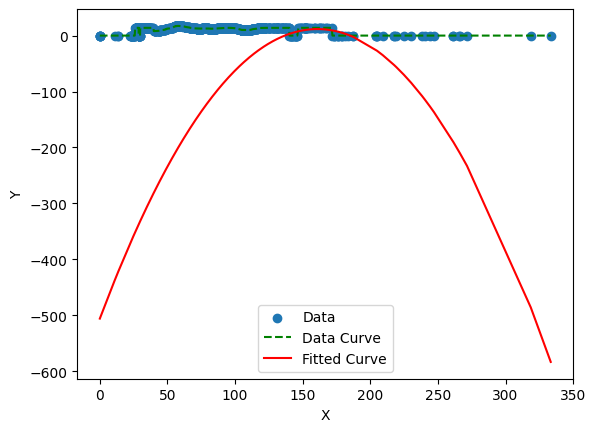

Fitted Parameters: a = 5.841689109802246, b = 5.807647228240967, c = 5.841689109802246
Loss: 34521167.1697206


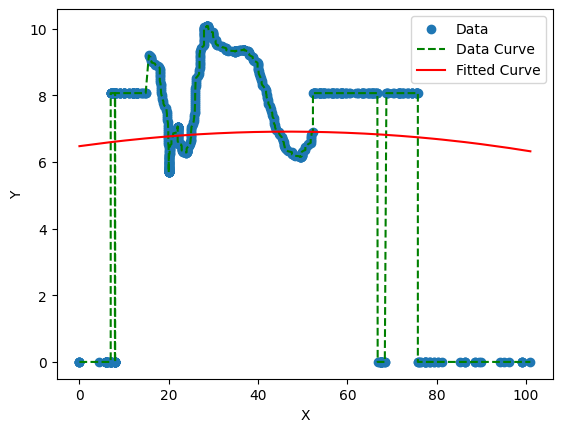

Fitted Parameters: a = 3.454303503036499, b = 3.8071038722991943, c = 3.454303503036499
Loss: 6488.882015922776


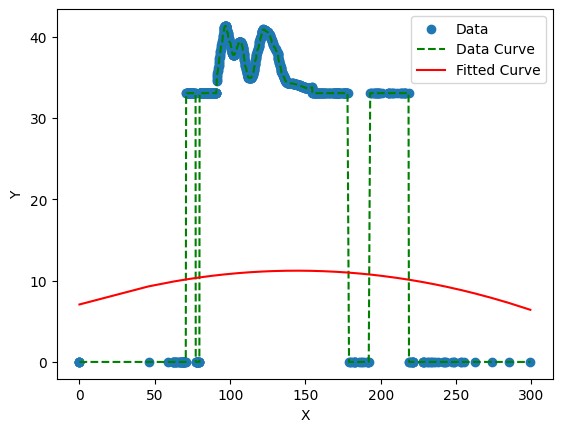

Fitted Parameters: a = 5.61021089553833, b = 5.482867240905762, c = 5.61021089553833
Loss: 502010.67878353747


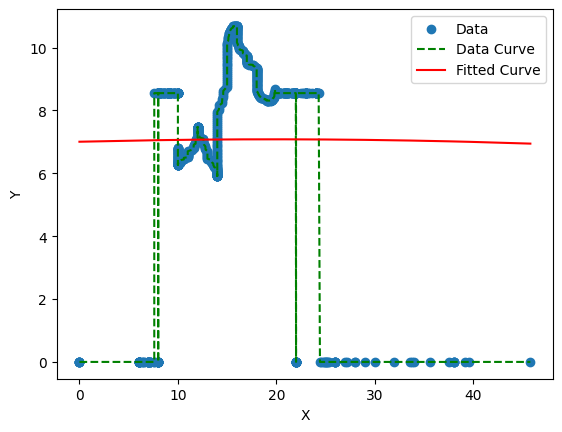

Fitted Parameters: a = 3.5403294563293457, b = 3.2913553714752197, c = 3.5403294563293457
Loss: 7461.893443595948


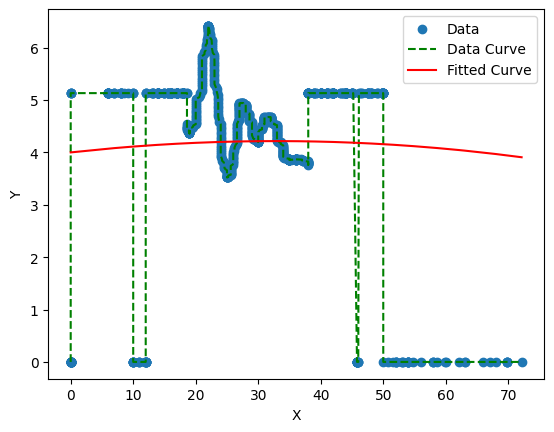

Fitted Parameters: a = 2.1082162857055664, b = 3.199436902999878, c = 2.1082162857055664
Loss: 2303.347272489177


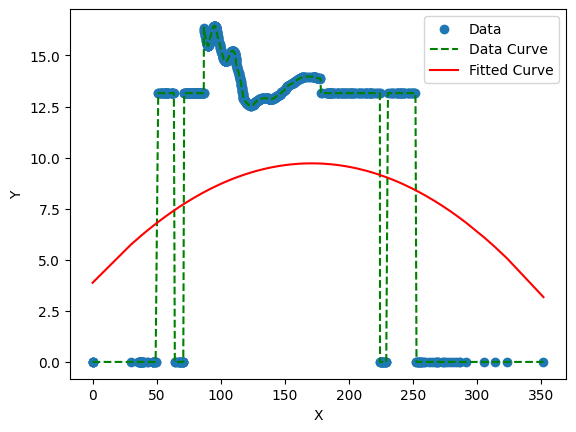

Fitted Parameters: a = 4.860079765319824, b = 4.987367153167725, c = 4.860079765319824
Loss: 26821.22672222633


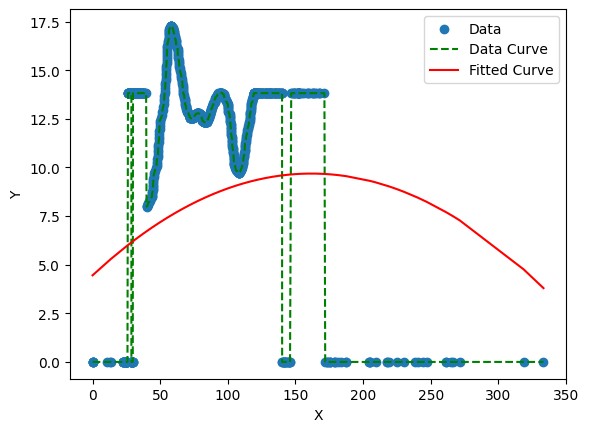

Fitted Parameters: a = 4.84379768371582, b = 4.9399800300598145, c = 4.84379768371582
Loss: 28723.469478707273


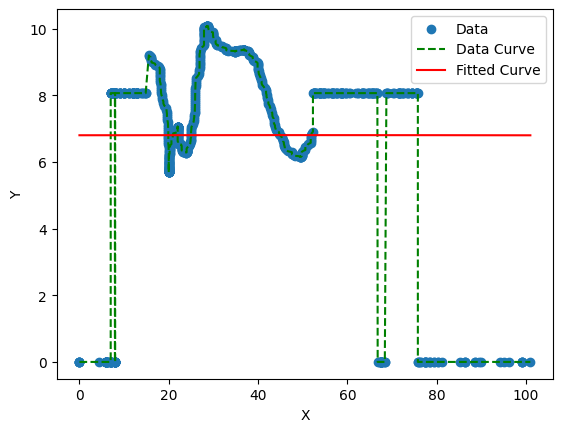

Fitted Parameters: a = 3.4022412300109863, b = 3.7435221672058105, c = 3.4022412300109863
Loss: 6740.337784250254


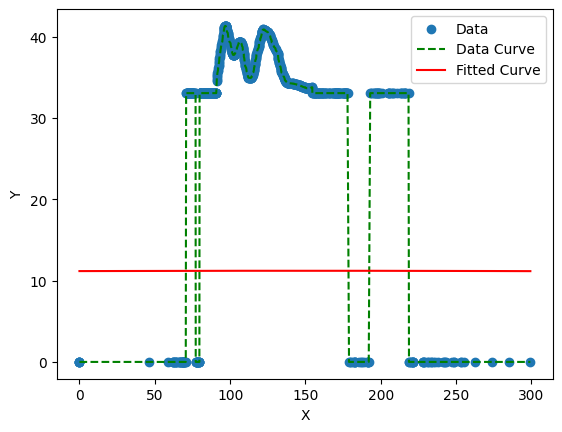

Fitted Parameters: a = 5.605490684509277, b = 5.483163833618164, c = 5.605490684509277
Loss: 493848.57723238645


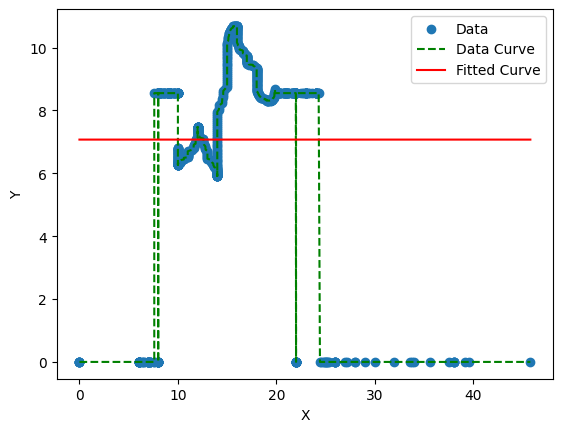

Fitted Parameters: a = 3.5361995697021484, b = 3.2805237770080566, c = 3.5361995697021484
Loss: 7496.425079711546


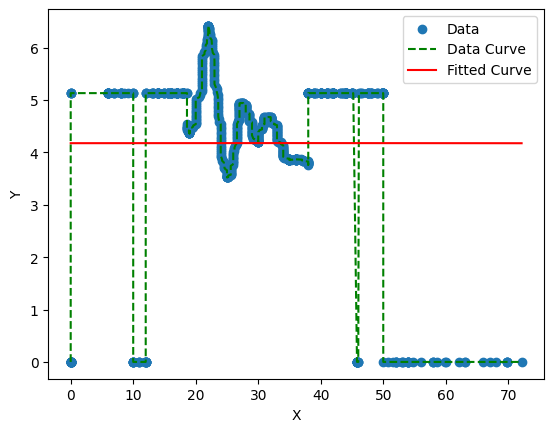

Fitted Parameters: a = 2.089289665222168, b = 3.0798070430755615, c = 2.089289665222168
Loss: 2388.85695926248


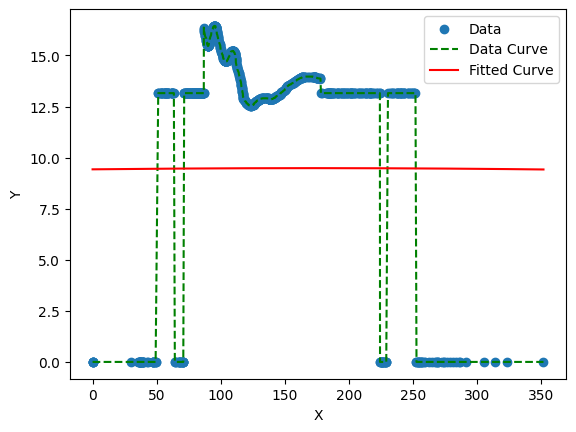

Fitted Parameters: a = 4.742725372314453, b = 4.861911296844482, c = 4.742725372314453
Loss: 25702.257240876956


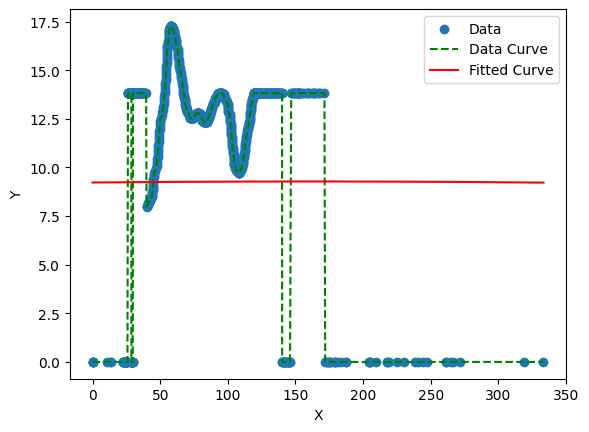

Fitted Parameters: a = 4.640340328216553, b = 4.705294609069824, c = 4.640340328216553
Loss: 22807.40456260863


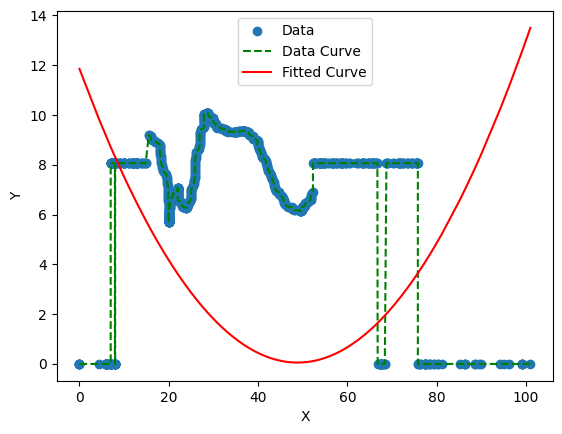

Fitted Parameters: a = 0.004944170359522104, b = 1.6460983753204346, c = 0.05412319675087929
Loss: 30390.13238699967


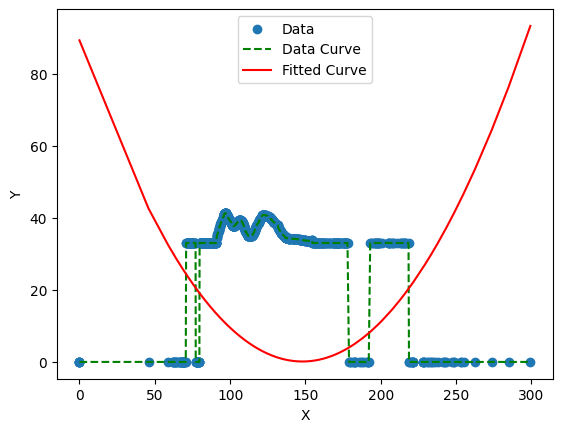

Fitted Parameters: a = 0.004075172822922468, b = 1.6413060426712036, c = 0.11674736440181732
Loss: 810117.3040202169


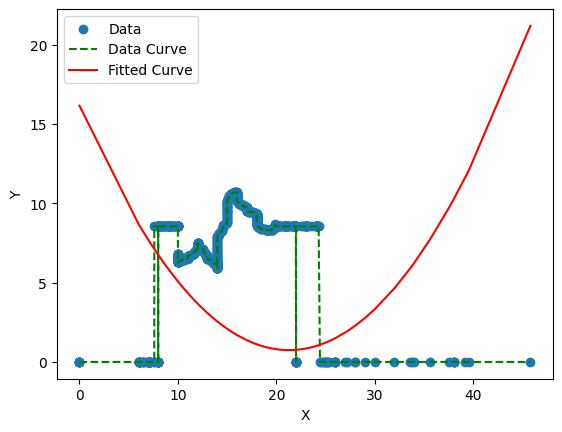

Fitted Parameters: a = 0.034012556076049805, b = 1.6131110191345215, c = 0.7464656233787537
Loss: 33626.329491760654


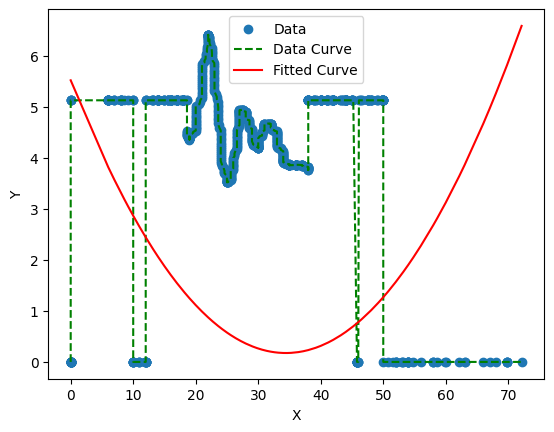

Fitted Parameters: a = 0.004513880703598261, b = 1.638363003730774, c = 0.17467890679836273
Loss: 14143.318962374467


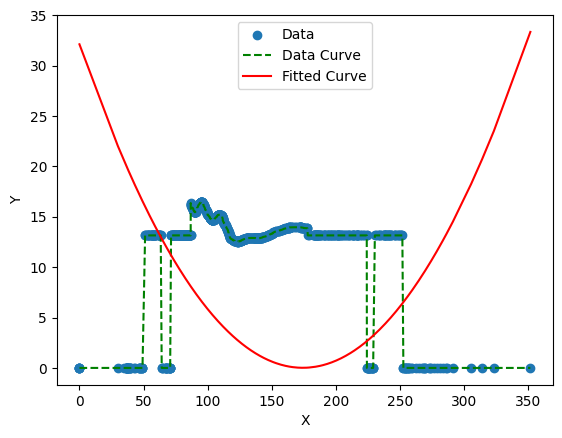

Fitted Parameters: a = 0.0010571778984740376, b = 1.650821566581726, c = 0.013486834242939949
Loss: 100570.50904630692


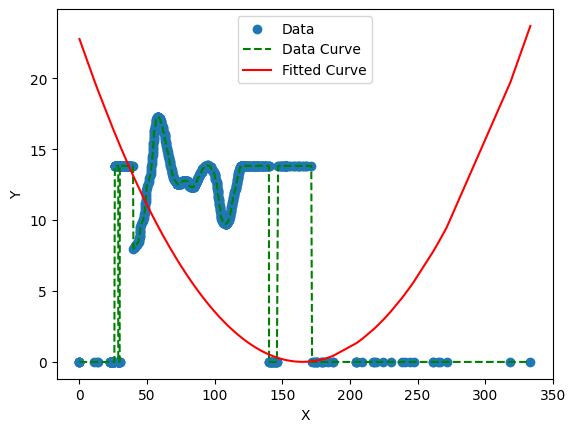

Fitted Parameters: a = 0.0008358292398042977, b = 1.6527448892593384, c = 0.004343940876424313
Loss: 65897.62242033135


In [91]:
x_data_dict = x_fft_dict
y_data_dict = y_fft_dict
# 定义非线性模型 a * np.exp(b * x) + c
def nonlinear_model(x, a, b, c):
    return  a * (x - max(x)/2 + b )**2 + c

# 定义损失函数：均方误差
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

for key, item in x_data_dict.items():
    x_data = item
    y_data = y_data_dict[key]
    # 初始化模型参数
    a = tf.Variable(1.0, dtype=tf.float32)
    b = tf.Variable(1.0, dtype=tf.float32)
    c = tf.Variable(1.0, dtype=tf.float32)

    # 使用Adam优化器
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # 训练模型
    epochs = 500
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = nonlinear_model(x_data, a, b, c)
            loss = loss_function(y_data, y_pred)
        gradients = tape.gradient(loss, [a, b, c])
        optimizer.apply_gradients(zip(gradients, [a, b, c]))

    # 获取拟合的参数
    a_fit, b_fit, c_fit = a.numpy(), b.numpy(), c.numpy()

    # 生成拟合曲线的预测值
    y_fit = nonlinear_model(x_data, a_fit, b_fit, c_fit)

    # 绘制原始数据、平滑数据和拟合曲线
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, y_data, label='Data Curve', color='green', linestyle='--')
    plt.plot(x_data, y_fit, label='Fitted Curve', color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    # 打印拟合的参数
    print(f'Fitted Parameters: a = {a_fit}, b = {b_fit}, c = {c_fit}')

    # 计算残差平方和作为损失值
    residuals = y_data - y_fit
    loss = np.sum(residuals**2)

    # 打印损失值
    print(f'Loss: {loss}')
